In [38]:
# https://www.kaggle.com/c/avazu-ctr-prediction/data

df= spark.read.csv("train.gz",header=True,mode="DROPMALFORMED")
df.printSchema()
print('nrows:',df.count())

root
 |-- id: string (nullable = true)
 |-- click: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- C1: string (nullable = true)
 |-- banner_pos: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C17: string (nullable = true)
 |-- C18: string (nullable = true)
 |-- C19: string (nullable = true)
 |-- C20: string (nullable = true)
 |-- C21: string (nullable = true)

nrows: 40428967


### Sample 5% of data for Quick Testing

In [40]:
df = df.sample(False,0.05,1234)
print('sampled nrows:',df.count())

sampled nrows: 101517


In [41]:
from pyspark.sql.functions import *

# check dates
df.select('hour').show(5)


# clean dates
df = df.withColumn('date', concat(df.hour.substr(0, 2),
                                  lit('-'),df.hour.substr(3,2),
                                  lit('-'),df.hour.substr(5,2),
                                 ))

df = df.withColumn('hour', concat(df.hour.substr(7,2)))

df = df.withColumn('date',to_date('date','yy-MM-dd'))
#df = df.withColumn('date',to_timestamp('date','yy-MM-dd'))

df.select('hour','date').show(5)
df.printSchema()

+--------+
|    hour|
+--------+
|14102100|
|14102100|
|14102100|
|14102100|
|14102100|
+--------+
only showing top 5 rows

+----+----------+
|hour|      date|
+----+----------+
|  00|2014-10-21|
|  00|2014-10-21|
|  00|2014-10-21|
|  00|2014-10-21|
|  00|2014-10-21|
+----+----------+
only showing top 5 rows

root
 |-- id: string (nullable = true)
 |-- click: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- C1: string (nullable = true)
 |-- banner_pos: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: string (nullable = true)
 |-- C14: string (nullable = true

### Date Features: day

In [42]:
from datetime import datetime, timedelta
from time import time
#from pyspark.sql.functions import date_format,hour

df = df.withColumn("day",date_format('date', 'E') )
df.select('date','day').show(5)

+----------+---+
|      date|day|
+----------+---+
|2014-10-21|Tue|
|2014-10-21|Tue|
|2014-10-21|Tue|
|2014-10-21|Tue|
|2014-10-21|Tue|
+----------+---+
only showing top 5 rows



### Cast to Integers 

In [43]:
myint = ['click','hour','C1','banner_pos','device_conn_type',
        'C14','C15','C16','C17','C18','C19','C20','C21']

for i in myint:
    df = df.withColumn((i),df[i].cast('integer'))
    
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- day: string 

### Clean Feature: Source (from app & site features)

In [44]:
from pyspark.sql import functions as F

# feature SOURCE_ID
df = df.withColumn('source_id',
                   F.when(df['app_id']=='ecad2386',df['site_id'])\
                    .when(df['site_id']=='85f751fd',df['app_id'])\
                  )

# feature SOURCE_DOMAIN
df = df.withColumn('source_domain',F.when(df['app_id']=='ecad2386',df['site_domain'])\
                                    .when(df['site_id']=='85f751fd',df['app_domain']))

# feature SOURCE_category
df = df.withColumn('source_category',F.when(df['app_id']=='ecad2386',df['site_category'])\
                                    .when(df['site_id']=='85f751fd',df['app_category']))


### New  Categorical Feature: banner_size

In [45]:
df = df.withColumn('banner_size',concat(df.C15,lit('x'),df.C16))
df.select('banner_size').show(5)

+-----------+
|banner_size|
+-----------+
|     320x50|
|     320x50|
|     320x50|
|     300x50|
|     320x50|
+-----------+
only showing top 5 rows



### Other Features Engineering

In [46]:
df = (df
      .withColumn('pos_conn_type',concat(df['banner_pos'],lit('_'),df['device_conn_type']))
      .withColumn('source_id_pos',concat(df['source_id'],lit('_'),df['banner_pos']  ))
     )


In [47]:
#DROP COLS
df = df.drop('id','device_id','device_ip')
df.printSchema()
#df.show(1)

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- day: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- source_domain: string (nullable = true)
 |-- source_

In [48]:
#WRITE TO CSV FOLDER
import shutil
myfoldername = "df_sampled"
if os.path.isdir(myfoldername):shutil.rmtree(myfoldername)
df.coalesce(1)\
.write\
.format("com.databricks.spark.csv")\
.option("header", "true")\
.save(myfoldername)
print('write csv done!')

write csv done!


### Read csv to Pandas dataframe

In [1]:
import pandas as pd
import numpy as np


df = pd.read_csv('df_sampled.csv', sep=',')
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C20,C21,date,day,source_id,source_domain,source_category,banner_size,pos_conn_type,source_id_pos
0,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,100084,79,2014-10-21T00:00:00.000+08:00,Tue,1fbe01fe,f3845767,28905ebd,320x50,0_0,1fbe01fe_0
1,0,0,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,...,-1,32,2014-10-21T00:00:00.000+08:00,Tue,0c2fe9d6,27e3c518,28905ebd,320x50,1_0,0c2fe9d6_1
2,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,-1,79,2014-10-21T00:00:00.000+08:00,Tue,1fbe01fe,f3845767,28905ebd,320x50,0_0,1fbe01fe_0
3,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,...,-1,79,2014-10-21T00:00:00.000+08:00,Tue,e2a1ca37,2347f47a,8ded1f7a,320x50,0_0,e2a1ca37_0
4,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,-1,79,2014-10-21T00:00:00.000+08:00,Tue,1fbe01fe,f3845767,28905ebd,320x50,0_0,1fbe01fe_0


In [2]:
df = df.drop(['site_id','site_domain','site_category','app_id','app_domain','app_category'], axis=1)

In [3]:
df.dtypes

click                int64
hour                 int64
C1                   int64
banner_pos           int64
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
date                object
day                 object
source_id           object
source_domain       object
source_category     object
banner_size         object
pos_conn_type       object
source_id_pos       object
dtype: object

In [4]:
df.shape

(2022988, 23)

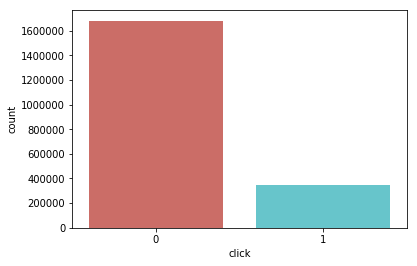

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



sns.countplot(x='click',data=df, palette='hls')
plt.show();


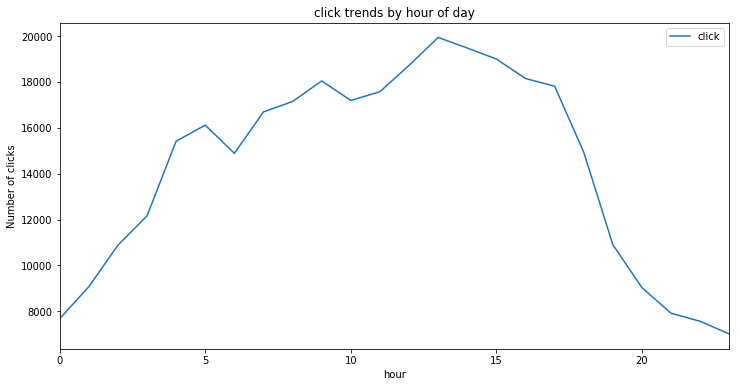

In [53]:
df.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

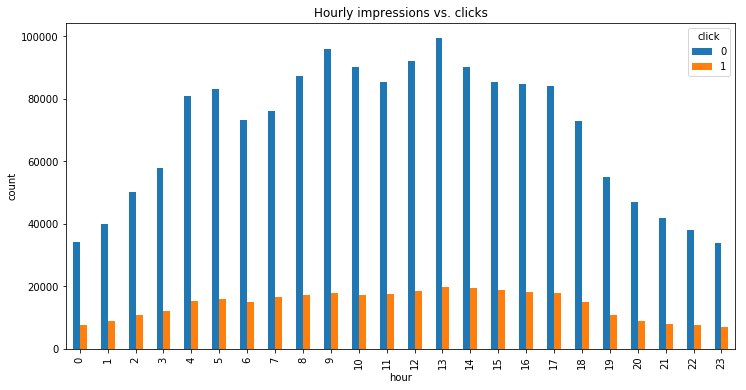

In [54]:
df.groupby(['hour', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

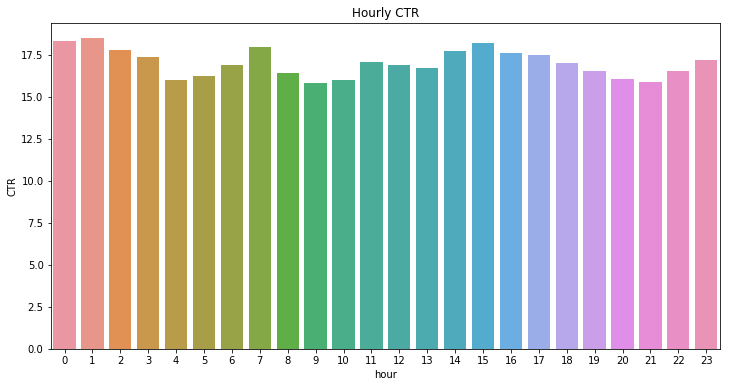

In [55]:
import seaborn as sns

df_click = df[df['click'] == 1]
df_hour = df[['hour','click']].groupby(['hour']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour','click']].groupby(['hour']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour', data=df_hour)
plt.title('Hourly CTR');

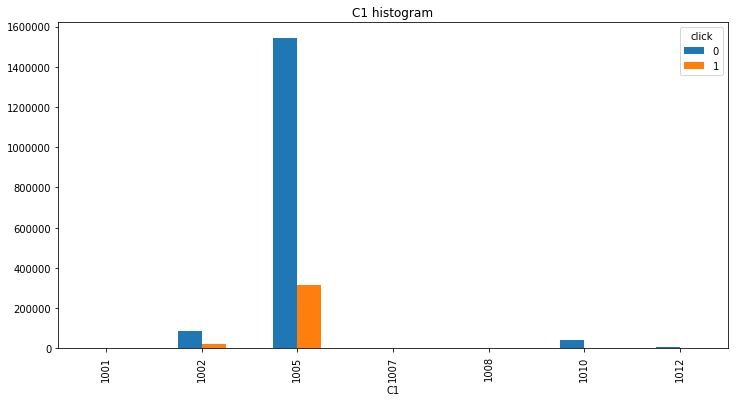

In [59]:
df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

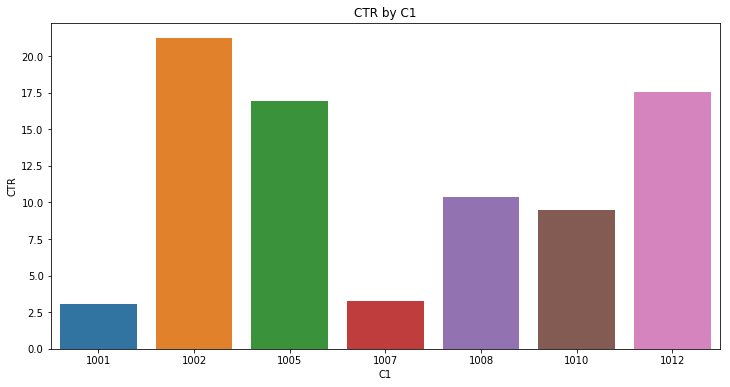

In [60]:
df_c1 = df[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

In [66]:
print('Average CTR:',df['click'].mean())

Average CTR: 0.16969700265152338


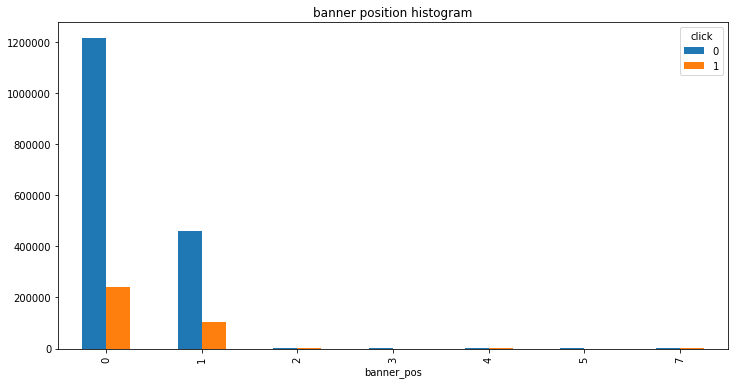

In [67]:
df.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');


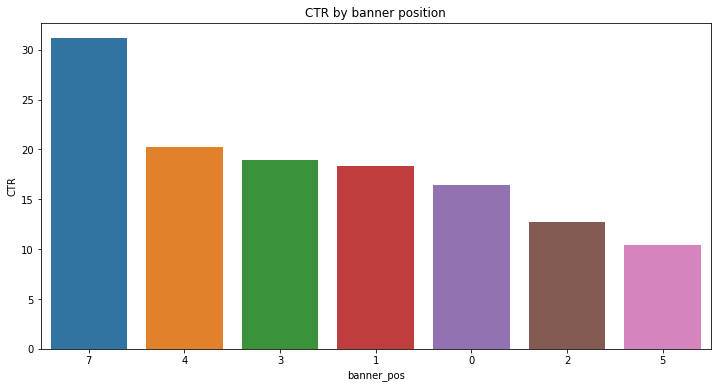

In [68]:
df_banner = df[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

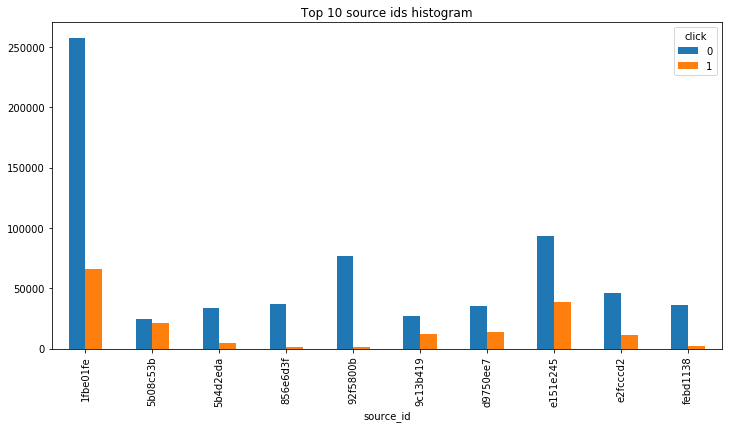

In [72]:
top10_sources = df[(df.source_id.isin((df.source_id.value_counts()/len(df))[0:10].index))]
top10_sources_click = top10_sources[top10_sources['click'] == 1]
top10_sources.groupby(['source_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 source ids histogram');



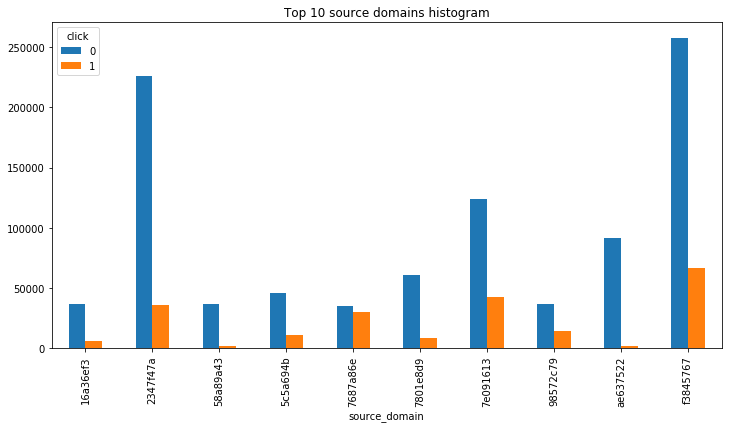

In [73]:
top10_domain = df[(df.source_domain.isin((df.source_domain.value_counts()/len(df))[0:10].index))]
top10_domain_click = top10_domain[top10_domain['click'] == 1]
top10_domain.groupby(['source_domain', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 source domains histogram');


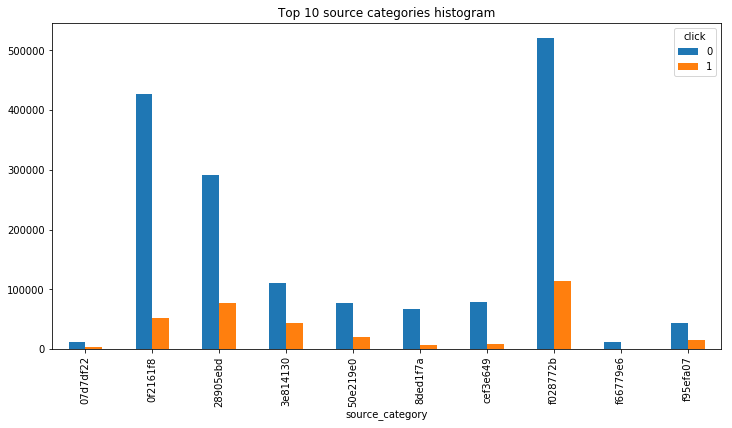

In [74]:
top10_category = df[(df.source_category.isin((df.source_category.value_counts()/len(df))[0:10].index))]
top10_category_click = top10_category[top10_category['click'] == 1]
top10_category.groupby(['source_category', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 source categories histogram');


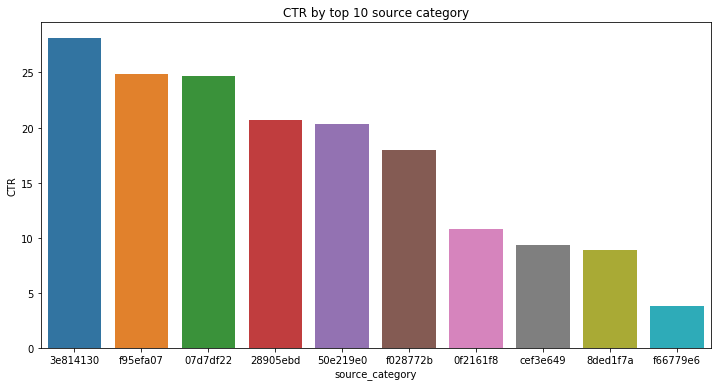

In [75]:
df_category = top10_category[['source_category','click']].groupby(['source_category']).count().reset_index()
df_category = df_category.rename(columns={'click': 'impressions'})
df_category['clicks'] = top10_category_click[['source_category','click']].groupby(['source_category']).count().reset_index()['click']
df_category['CTR'] = df_category['clicks']/df_category['impressions']*100
sort_category = df_category.sort_values(by='CTR',ascending=False)['source_category'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='source_category', data=df_category, order=sort_category)
plt.title('CTR by top 10 source category');


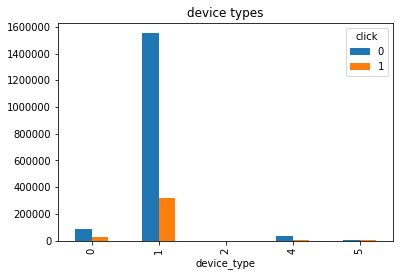

In [76]:
df[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');


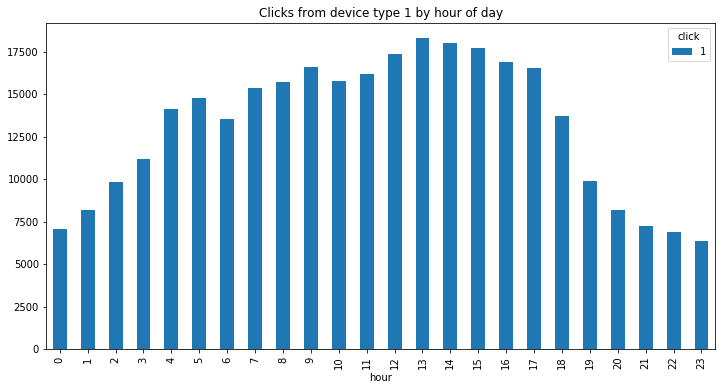

In [77]:
df_click[df_click['device_type']==1].groupby(['hour', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));


In [78]:
print("There are {} C14 in the data set".format(df.C14.nunique()))
print("There are {} C15 in the data set".format(df.C15.nunique()))
print("There are {} C16 in the data set".format(df.C16.nunique()))
print("There are {} C17 in the data set".format(df.C17.nunique()))
print("There are {} C18 in the data set".format(df.C18.nunique()))
print("There are {} C19 in the data set".format(df.C19.nunique()))
print("There are {} C20 in the data set".format(df.C20.nunique()))

There are 2359 C14 in the data set
There are 8 C15 in the data set
There are 9 C16 in the data set
There are 422 C17 in the data set
There are 4 C18 in the data set
There are 66 C19 in the data set
There are 166 C20 in the data set


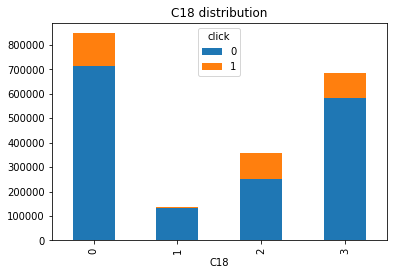

In [79]:
df.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution');


### Run XGBoost to extract variable of importance & check for masking effect
* partition
* drop unwanted variables
* feature hash obj variables

In [5]:
df = df.drop(['device_model','date'], axis=1)


In [6]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self


df = convert_obj_to_int(df)

In [33]:
X = df.drop(['click','C15','C16'], axis=1)

y = df["click"]

In [34]:
X_list = list(X.columns)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [36]:
import xgboost as xgb

import pickle
from geopy.geocoders import Nominatim




#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'binary:logistic',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'eval_metric': 'logloss',
    #'feval':              'auc'#'rmsle'
}

In [37]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

#this is for tracking the error
watchlist = [(dval, 'eval'), (dtrain, 'train')]

/Users/dreameshuggah/anaconda2/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [38]:
#Train model



gbm = xgb.train(params,
                dtrain,
                num_boost_round = 50,
                evals = watchlist,
                early_stopping_rounds=10,
                verbose_eval = True
                )

[0]	eval-logloss:0.669012	train-logloss:0.668795
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 10 rounds.
[1]	eval-logloss:0.647541	train-logloss:0.647626
[2]	eval-logloss:0.627542	train-logloss:0.62662
[3]	eval-logloss:0.609781	train-logloss:0.609733
[4]	eval-logloss:0.59335	train-logloss:0.591945
[5]	eval-logloss:0.578576	train-logloss:0.5782
[6]	eval-logloss:0.564924	train-logloss:0.563351
[7]	eval-logloss:0.552281	train-logloss:0.550693
[8]	eval-logloss:0.540783	train-logloss:0.538894
[9]	eval-logloss:0.5301	train-logloss:0.528353
[10]	eval-logloss:0.520171	train-logloss:0.518294
[11]	eval-logloss:0.511164	train-logloss:0.509523
[12]	eval-logloss:0.502845	train-logloss:0.500629
[13]	eval-logloss:0.495143	train-logloss:0.492802
[14]	eval-logloss:0.4881	train-logloss:0.485302
[15]	eval-logloss:0.48153	train-logloss:0.478865
[16]	eval-logloss:0.475379	train-logloss:0.472427
[17]	eval-logloss:

### Feature Importance:
* F score is a metric that simply sums up how many times each feature is split on.

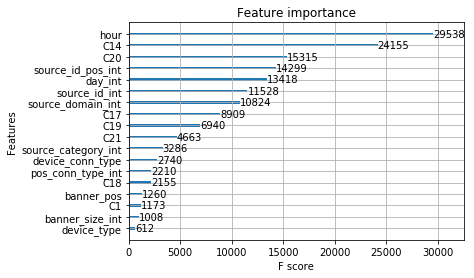

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(figsize=(18, 18))

xgb.plot_importance(gbm)

# F score is a metric that simply sums up how many times each feature is split on.

In [40]:
#Test predictions
pred = gbm.predict(xgb.DMatrix(X_test), ntree_limit=gbm.best_ntree_limit)
print(type(pred))
pred[:10]

<class 'numpy.ndarray'>


array([0.19949052, 0.08399887, 0.14428438, 0.21007769, 0.17427774,
       0.18451394, 0.43144444, 0.2342752 , 0.28948176, 0.32806984],
      dtype=float32)

In [41]:
print ('================= Model Evaluation: AUC & Logloss ==================================')
from sklearn import metrics
from sklearn.metrics import log_loss

obs = y_test

fpr, tpr, thresholds = metrics.roc_curve(obs, pred)

#print('tpr:',tpr)
#print('fpr:',fpr)

auc = metrics.auc(fpr,tpr)
logloss_score = log_loss(obs, pred, eps=1e-15)

print ('AUC =', auc)
print ('logloss =', logloss_score)

================= Model Evaluation: AUC & Logloss ==================================
AUC = 0.7460610503357532
logloss = 0.4038926614535791


In [32]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))